In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets


In [41]:
"""This part reads all csv files of the LUCAS 2015 dataset. It reads the reflectance
values and OC values of all given location points and puts it in a pandas dataframe"""

# Every land code, each code is a csv file.
LC = ["AT", "BE", "NL", "DE", "UK","EL", "EE","DK", "CZ", "CY", "BG", "FI", "FR",
      "HR", "HU","IE", "IT", "LT", "LU", "LV", "MT", "PL", "PT", "RO","SE", "SI", "SK"]

result = pd.DataFrame()
spec = pd.read_csv(r'C:\Users\User\Documents\LUCAS2015_topsoildata_20200323\LUCAS_Topsoil_2015_20200323.csv')

for c in LC:
    df = pd.read_csv(r"C:\Users\User\Documents\LUCAS2015_spectra\LUCAS2015_Soil_Spectra_EU28\spectra_ "+c+" .csv")
    columns = df.columns[5:]
    columns = columns.insert(0, 'PointID')
    left = df[columns]
    right = spec[['Point_ID', 'OC']]
    right = right.rename(columns={'Point_ID': 'PointID'})
    r = pd.merge(left, right, on="PointID")
    result = pd.concat([result, r], axis=0)
result

,PointID,400,400.5,401,401.5,402,402.5,403,403.5,404,...,2495.5,2496,2496.5,2497,2497.5,2498,2498.5,2499,2499.5,OC
0,46442722,0.901924,0.907745,0.913509,0.919191,0.924762,0.930197,0.935479,0.940585,0.945503,...,0.681045,0.681039,0.681024,0.681001,0.680971,0.680936,0.680897,0.680853,0.680794,36.3
1,46442722,0.898363,0.904257,0.910094,0.915846,0.921486,0.926987,0.932330,0.937492,0.942457,...,0.677963,0.677970,0.677974,0.677974,0.677971,0.677963,0.677951,0.677934,0.677908,36.3
2,46522722,0.870422,0.876326,0.882174,0.887940,0.893597,0.899119,0.904488,0.909685,0.914694,...,0.604487,0.604457,0.604425,0.604390,0.604355,0.604319,0.604284,0.604248,0.604204,42.6
3,46522722,0.869277,0.875201,0.881073,0.886863,0.892548,0.898098,0.903495,0.908716,0.913746,...,0.602782,0.602775,0.602761,0.602740,0.602711,0.602675,0.602634,0.602588,0.602525,42.6
4,46882726,0.937757,0.944273,0.950737,0.957122,0.963402,0.969554,0.975558,0.981393,0.987043,...,0.660686,0.660632,0.660573,0.660508,0.660440,0.660369,0.660294,0.660218,0.660117,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,48482874,0.804873,0.812589,0.820333,0.828019,0.835624,0.843117,0.850475,0.857677,0.864703,...,0.458666,0.458778,0.458881,0.458979,0.459073,0.459165,0.459258,0.459354,0.459489,17.1
452,50722882,0.713708,0.721776,0.729873,0.737912,0.745862,0.753694,0.761384,0.768904,0.776234,...,0.472882,0.472955,0.473020,0.473078,0.473132,0.473184,0.473235,0.473287,0.473360,50.3
453,50722882,0.714726,0.722801,0.730902,0.738935,0.746873,0.754686,0.762347,0.769831,0.777123,...,0.474116,0.474202,0.474273,0.474331,0.474379,0.474419,0.474455,0.474490,0.474539,50.3
454,51822906,0.721657,0.728295,0.734950,0.741537,0.748024,0.754379,0.760583,0.766609,0.772445,...,0.582359,0.582545,0.582723,0.582896,0.583068,0.583241,0.583418,0.583600,0.583855,24.1


In [42]:
"""Filters every 20th reflectance value, it has been shown to increase the accuracy of
our model and also speeds up the fitting process"""
filt_columns = list(result.columns[::20])
filt_columns.append("OC")
result = result[filt_columns]

In [43]:
"""Remove all strong outliers of the OC values in the dataset"""
Q1 = result['OC'].quantile(0.25)
Q3 = result['OC'].quantile(0.75)
IQR = Q3 - Q1
print(Q1, Q3, IQR)
result = result[result['OC'] < Q3 + IQR * 3]
result = result[result['OC'] > Q1 - IQR * 3]

13.5 41.3 27.799999999999997


In [44]:
"""reset the index numbering now that outliers have been removed."""
U_result = result.reset_index()
result["OC"].describe()
U_result

,index,PointID,409.5,419.5,429.5,439.5,449.5,459.5,469.5,479.5,...,2419.5,2429.5,2439.5,2449.5,2459.5,2469.5,2479.5,2489.5,2499.5,OC
0,0,46442722,0.985558,1.007213,1.003629,0.995483,0.985682,0.978635,0.972658,0.964527,...,0.669978,0.671728,0.673648,0.675380,0.677033,0.678658,0.680008,0.680791,0.680794,36.3
1,1,46442722,0.982877,1.004829,1.001294,0.993286,0.983573,0.976518,0.970495,0.962371,...,0.666990,0.668785,0.670535,0.672426,0.674035,0.675646,0.676876,0.677776,0.677908,36.3
2,2,46522722,0.955810,0.980547,0.982152,0.981020,0.977294,0.973587,0.969281,0.963023,...,0.589349,0.593302,0.596833,0.599223,0.600816,0.602260,0.603495,0.604411,0.604204,42.6
3,3,46522722,0.954940,0.979871,0.981555,0.980586,0.976931,0.973176,0.968851,0.962510,...,0.587650,0.591586,0.595153,0.597512,0.599172,0.600486,0.601739,0.602652,0.602525,42.6
4,4,46882726,1.034908,1.066607,1.073910,1.077711,1.078004,1.078778,1.079786,1.078386,...,0.653644,0.656006,0.658001,0.659109,0.659736,0.660283,0.660664,0.660907,0.660117,37.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32916,451,48482874,0.926701,0.975212,0.991746,1.004107,1.010485,1.013445,1.014775,1.013299,...,0.424765,0.430453,0.436292,0.441130,0.445187,0.449330,0.453158,0.456894,0.459489,17.1
32917,452,50722882,0.840788,0.891222,0.907285,0.917173,0.920113,0.921714,0.922795,0.920105,...,0.432122,0.439472,0.447555,0.453885,0.458669,0.463058,0.467030,0.471381,0.473360,50.3
32918,453,50722882,0.841519,0.892063,0.908127,0.918090,0.921052,0.922623,0.923683,0.921070,...,0.433322,0.440550,0.448609,0.454938,0.459900,0.464226,0.468192,0.472577,0.474539,50.3
32919,454,51822906,0.822234,0.856905,0.862406,0.862533,0.858464,0.854815,0.851798,0.847157,...,0.534815,0.542509,0.550557,0.557315,0.562983,0.568743,0.574316,0.579725,0.583855,24.1


In [45]:
"""Seperate the dataset into its label (y) and input data (X)"""
X = U_result[U_result.columns[1:-1]].values
y = U_result[U_result.columns[-1]].values
print(y)
print(X)

[36.3 36.3 42.6 ... 50.3 24.1 24.1]
[[4.6442722e+07 9.8555800e-01 1.0072130e+00 ... 6.8000800e-01
  6.8079100e-01 6.8079400e-01]
 [4.6442722e+07 9.8287700e-01 1.0048290e+00 ... 6.7687600e-01
  6.7777600e-01 6.7790800e-01]
 [4.6522722e+07 9.5581000e-01 9.8054700e-01 ... 6.0349500e-01
  6.0441100e-01 6.0420400e-01]
 ...
 [5.0722882e+07 8.4151900e-01 8.9206300e-01 ... 4.6819200e-01
  4.7257700e-01 4.7453900e-01]
 [5.1822906e+07 8.2223400e-01 8.5690500e-01 ... 5.7431600e-01
  5.7972500e-01 5.8385500e-01]
 [5.1822906e+07 8.2285200e-01 8.5722500e-01 ... 5.7621100e-01
  5.8168300e-01 5.8573900e-01]]


In [46]:
"""Turn all labels in categories. The values where continues values and are turned into
ranges of 2"""
maxvaluey = int(max(y))
ranges = 2
catlist = []
for i in y:
    for j in range(0, maxvaluey+ranges, ranges):
        if i >= j and i < j+ranges:
            catlist.append(f'{j}-{j+ranges}')
y = catlist

In [47]:
"""Split the data into train and test data, the test data is 9% of the entire dataset."""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.09,  random_state=3)
print(len(X_test))
print(len(X_train))

2963
29958


In [48]:
"""The KNN model, with a accuracy averaging 91%"""
neigh = KNeighborsClassifier(n_neighbors=2, weights='distance')
neigh.fit(X_train, y_train)
print(neigh.score(X_test, y_test))


0.9109011137360783


In [49]:
neigh.get_params()  # all parameters used in the model

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'distance'}

In [50]:
"""Prints out every wrong answer given by the model with the expected correct answer."""
counter = 0
predictions = neigh.predict(X_test)
for i in range(len(y_test)):
    if y_test[i] != predictions[i]:
        counter +=1
        print(y_test[i])
        print(predictions[i])
        print("-------------")
        
 # print out the amount of wrong answers and amount of predictions       
print(counter)
print(len(y_test))

24-26
26-28
-------------
30-32
20-22
-------------
14-16
46-48
-------------
32-34
46-48
-------------
34-36
20-22
-------------
16-18
0-2
-------------
16-18
18-20
-------------
24-26
12-14
-------------
20-22
8-10
-------------
32-34
28-30
-------------
24-26
16-18
-------------
12-14
16-18
-------------
6-8
8-10
-------------
86-88
68-70
-------------
6-8
8-10
-------------
30-32
84-86
-------------
62-64
10-12
-------------
48-50
64-66
-------------
26-28
38-40
-------------
16-18
20-22
-------------
28-30
74-76
-------------
30-32
20-22
-------------
10-12
14-16
-------------
24-26
10-12
-------------
30-32
18-20
-------------
30-32
10-12
-------------
96-98
18-20
-------------
24-26
34-36
-------------
10-12
16-18
-------------
24-26
14-16
-------------
38-40
24-26
-------------
90-92
40-42
-------------
12-14
30-32
-------------
16-18
20-22
-------------
8-10
28-30
-------------
24-26
20-22
-------------
10-12
16-18
-------------
20-22
12-14
-------------
8-10
26-28
-----------

# Plotting results

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

Text(0, 0.5, 'Scores')

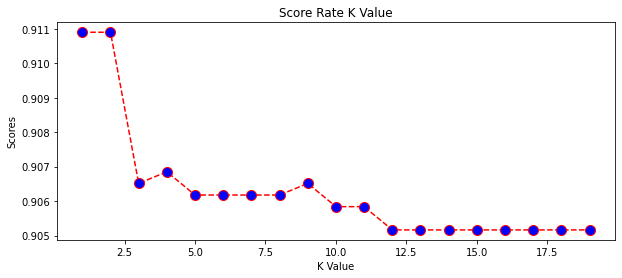

In [53]:
"""Plot effect ot the accuracy based on the K value"""
scores = []
# Calculating error for K values between 1 and 20
for i in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors=i, weights='distance')
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
    print(i, end=", ")

# plot score figure
plt.figure(figsize=(10, 4))
plt.plot(range(1, 20), scores, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Score Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Scores')

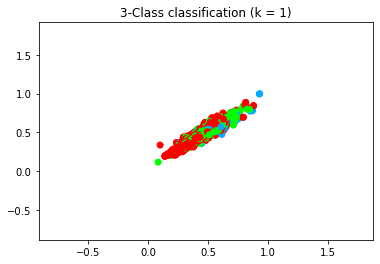

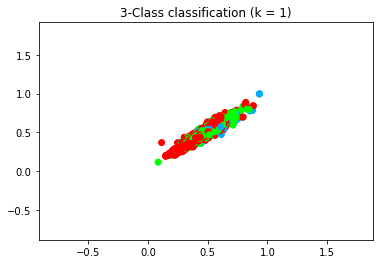

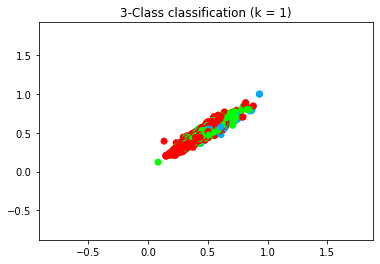

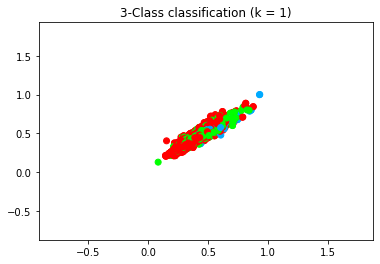

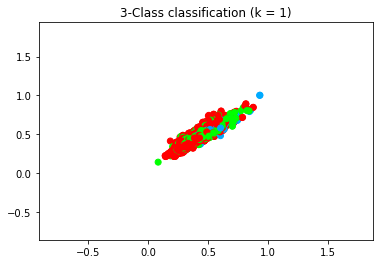

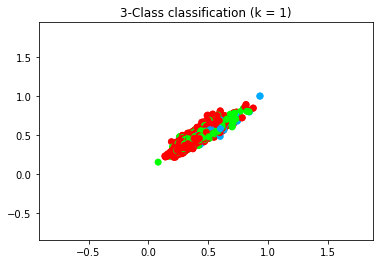

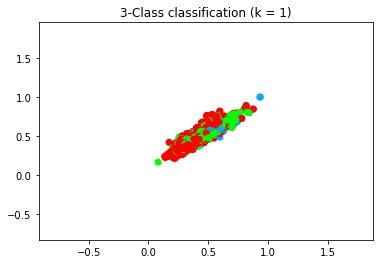

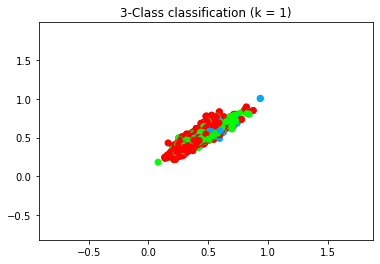

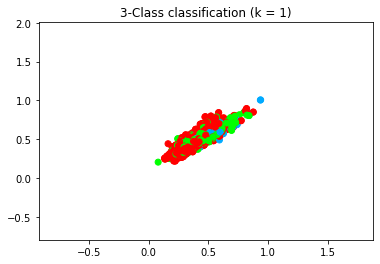

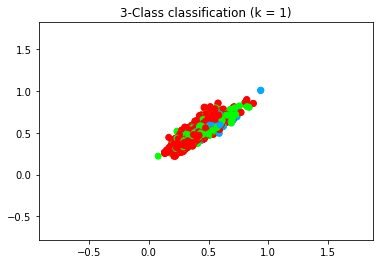

In [57]:

for i in range(100, 110):
    n_neighbors = 1

    # take the first two features
    Xplot = X_train[:, [i, i+100]]
    yplot = pd.factorize(np.array(y_train))[0]

    h = .2  # step size in the mesh

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])

    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    clf.fit(Xplot, yplot)

    # calculate min, max and limits
    x_min, x_max = Xplot[:, 0].min() - 1, Xplot[:, 0].max() + 1
    y_min, y_max = Xplot[:, 1].min() - 1, Xplot[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h))

    # predict class using data and kNN classifier
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    #plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(Xplot[:, 0], Xplot[:, 1], c=yplot, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i)" % (n_neighbors))
    plt.show()

<ipython-input-135-65125f69e2d2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf['OC_cat'] = catlist


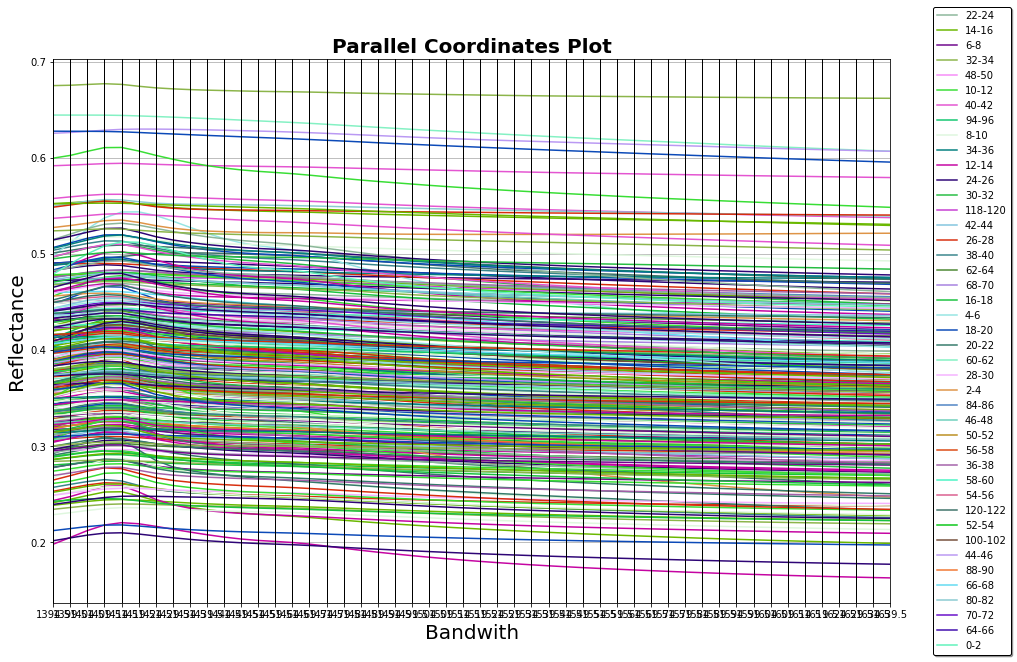

In [135]:

from pandas.plotting import parallel_coordinates
tempcolumns = U_result.columns[200:250]
tempdf = U_result[tempcolumns]
tempdf['OC_cat'] = catlist

plt.figure(figsize=(15,10))
parallel_coordinates(tempdf.sample(n=300), "OC_cat")
plt.title('Parallel Coordinates Plot', fontsize=20, fontweight='bold')
plt.xlabel('Bandwith', fontsize=20)
plt.ylabel('Reflectance', fontsize=20)
plt.legend(bbox_to_anchor=(1.15, 0.5), loc=5, prop={'size': 10}, 
           frameon=True,shadow=True, facecolor="white", edgecolor="black")
plt.show()
